# Image Reconstruction from Sinograms
## **A Tutorial on CT Reconstruction in NumPy and PyTorch**

## **Overview**
This tutorial explores how tomographic image reconstruction can be implemented using direct matrix methods and custom-coded forward/backprojection routines. The goal is to demystify CT reconstruction by showing how core techniques like **backprojection**, **filtered backprojection (FBP)**, and **iterative algorithms** such as **SIRT** and **CGLS** can be implemented from first principles.

We demonstrate that reconstructions can be achieved using two main approaches:
- A **matrix-based method**, where the forward model is explicitly represented as a system matrix **A**.
- A **functional method**, where forward and backprojectors are implemented using `scipy.ndimage.rotate` in for-loops.

Both approaches yield similar reconstruction results, and we will show their equivalence visually.

Importantly, this tutorial also introduces **GPU acceleration using PyTorch**, showcasing how much faster reconstructions become when using the same forward/backprojector logic with CUDA support. This is particularly useful when scaling to larger image sizes or for training machine learning models on synthetic reconstructions.

## **Objectives**
By the end of this tutorial, you will:
- Understand how to represent the CT forward model as a matrix **A** and use it for direct and iterative reconstruction.
- Implement custom forward and backprojectors using simple NumPy and `rotate`-based loops.
- Compare reconstruction quality and runtime across methods.
- Accelerate the same reconstruction logic using PyTorch with GPU support.
- Gain insight into why matrix methods don’t scale well and when loop-based approaches become preferable.

## **Reconstruction Methods Covered**

### **1. Backprojection (BP)**
The simplest form of reconstruction, implemented by smearing each projection back along its acquisition angle. It yields a blurred image but forms the basis for FBP and iterative methods.

### **2. Filtered Backprojection (FBP)**
A fast analytic method that applies a ramp filter in the frequency domain before backprojection. This produces high-quality results for noise-free or well-conditioned sinograms.

### **3. Iterative Methods: SIRT and CGLS**
These methods solve the inverse problem iteratively by minimizing the error between measured and simulated projections:
- **SIRT** (Simultaneous Iterative Reconstruction Technique) is simple and stable.
- **CGLS** (Conjugate Gradient for Least Squares) converges quickly and handles large systems efficiently.

### **4. Matrix-Based Forward Model**
The forward operator is represented explicitly as a sparse matrix **A**, allowing for direct inversion or use in iterative solvers via `A.T @ (A @ x - b)`. This method is mathematically transparent but limited in scalability due to memory constraints.

### **5. Custom Loop-Based Forward/Backward Operators**
Here, forward projection is performed using rotation-based integration across the object. This mimics the behavior of a real scanner and allows reconstruction on large-scale images without forming **A** explicitly.

### **6. PyTorch GPU Acceleration**
All of the above methods can be ported to PyTorch and run on GPU. This dramatically speeds up reconstruction, particularly for iterative methods or large sinogram stacks.

## **Why This Matters**
- Reconstruction is the core of computed tomography, and understanding how it works under the hood enables better debugging, algorithm development, and performance optimization.
- Many advanced ML-based approaches (e.g., learned iterative reconstructions) build on these foundations.
- This notebook provides a minimal, educational implementation of these techniques that can be scaled, extended, or incorporated into your own imaging workflows.

Let’s now walk through each reconstruction approach step by step — from matrix formulation to GPU acceleration — and evaluate their accuracy and performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon, radon
from tqdm import tqdm
import time
from nDTomo.sim.phantoms import SheppLogan
from nDTomo.tomo.conv_tomo import filter_sinogram, forwardproject, backproject, cgls, cgls_functional, sirt, sirt_functional, paralleltomo


First we create a phantom object that we will use for our simulations

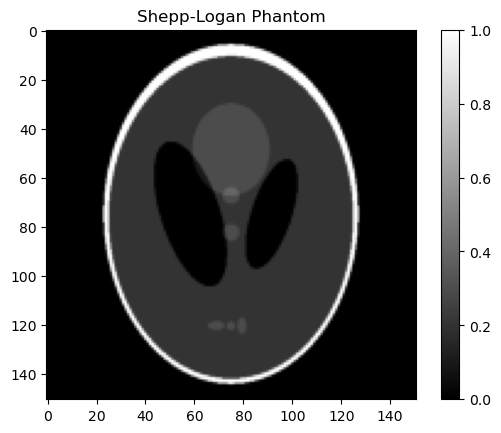

In [2]:
npix = 151
img = SheppLogan(npix)

plt.figure(1);plt.clf()
plt.imshow(img, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.colorbar()
plt.show()


### Filtering Sinograms in the Frequency Domain

Before performing backprojection, it's essential to filter the sinogram to correct for the inherent blurring introduced by the projection process. This is a key step in Filtered Backprojection (FBP) and is based on the physics of how the Radon transform behaves in frequency space.

The `filter_sinogram` function performs this filtering operation using the **Fourier slice theorem**, which states that each projection is a slice of the 2D Fourier transform of the object. Here's what happens:

1. **FFT Along Detector Axis**: Each projection (column in the sinogram) is Fourier transformed along the detector axis. This gives us a frequency representation of each projection.
2. **Apply Filter**: A filter is applied in the frequency domain. Two options are available:
   - **Ramp filter (Ram-Lak)**: Enhances high-frequency components to correct for blurring.
   - **Shepp-Logan filter**: A smoother version of the ramp, which reduces noise amplification by multiplying with a sinc function.
3. **Inverse FFT**: The filtered projections are transformed back to the spatial domain via inverse FFT.

This filtered sinogram can then be used for high-quality image reconstruction. Without this step, backprojection would produce a highly blurred result.

#### Code:
```python
def filter_sinogram(sinogram, filter_type='Ramp'):
    """
    Applies a frequency domain filter to a sinogram.

    Parameters
    ----------
    sinogram : ndarray
        2D array of shape (num_detectors, num_angles).
    filter_type : str
        Type of filter to apply. Options:
        - 'Ramp' : standard Ram-Lak filter
        - 'Shepp-Logan' : Ramp * sinc

    Returns
    -------
    filtered_sinogram : ndarray
        The filtered sinogram with the same shape as input.
    """
    n, n_theta = sinogram.shape
    f = fftfreq(n).reshape(-1, 1)

    # Ramp filter
    ramp = np.abs(f)

    if filter_type == 'Ramp':
        filt = ramp
    elif filter_type == 'Shepp-Logan':
        filt = ramp * np.sinc(f / (2 * f.max()))
    else:
        raise ValueError("Unsupported filter_type. Choose 'Ramp' or 'Shepp-Logan'.")

    # FFT along detector axis (rows)
    sino_fft = fft(sinogram, axis=0)
    sino_fft_filtered = sino_fft * filt
    filtered_sinogram = np.real(ifft(sino_fft_filtered, axis=0))

    return filtered_sinogram


The number of angles is 180
179.0


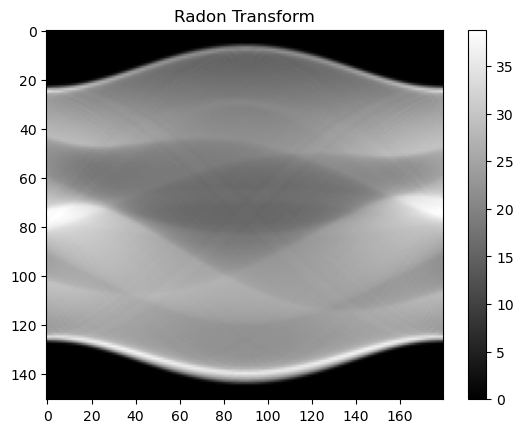

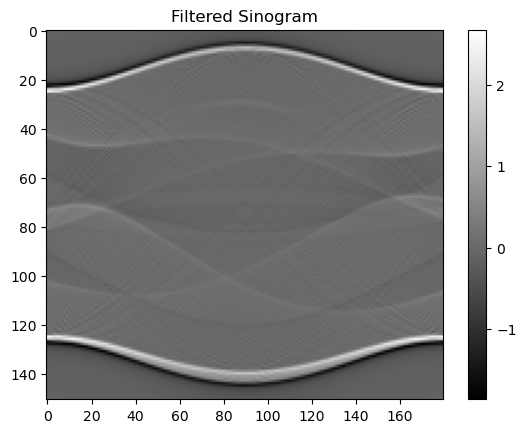

In [3]:

scan = 180
theta = np.linspace(0, scan, 180, endpoint=False)
print('The number of angles is', len(theta))
print(theta[-1])

s = radon(img, theta) 

fbp = iradon(s, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(s, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.axis('tight')
plt.show()

sf = filter_sinogram(s, filter_type='Ramp')

plt.figure(1);plt.clf()
plt.imshow(sf, cmap='gray')
plt.title('Filtered Sinogram')
plt.colorbar()
plt.axis('tight')
plt.show()


### Backprojection: Reconstructing from Filtered Projections

Backprojection is the process of reconstructing a 2D image from a set of 1D projections acquired at different angles. It's the core idea behind tomographic imaging, and here we implement it in the most intuitive way possible.

The `backproject` function works as follows:

1. **For Each Angle**:
   - A 1D projection is extracted from the sinogram.
   - This projection is **replicated along columns** to form a 2D image — this mimics smearing the projection across the reconstruction plane.
   - The 2D image is then **rotated to the corresponding acquisition angle** (plus 90° to align with the Radon geometry).

2. **Accumulation**:
   - Each rotated projection is **added** to the reconstruction buffer.
   - After all angles are processed, the image contains the accumulated backprojections.

3. **Normalization**:
   - The final result is scaled by π * N_theta, where N_theta is the number of projection angles. This compensates for overaccumulation during the sum.

This method visually reinforces the concept of backprojection: each projection "casts" its information across the reconstruction plane, and the full image is recovered by combining all such projections.

It’s a simple and elegant approach — ideal for learning and debugging — even though it’s slower than matrix-based or GPU-accelerated implementations.

#### Code:
```python

def backproject(sinogram, angles, output_size=None, scan=180):
    """
    Performs filtered or unfiltered backprojection of a sinogram.

    Parameters
    ----------
    sinogram : ndarray
        2D array of shape (num_detectors, num_angles).
    angles : ndarray
        1D array of projection angles in degrees.
    output_size : int, optional
        Size (width and height) of the reconstructed image.
        If None, use num_detectors from sinogram.

    Returns
    -------
    reconstruction : ndarray
        2D reconstructed image.
    """
    n_detectors, n_angles = sinogram.shape
    if output_size is None:
        output_size = n_detectors

    reconstruction = np.zeros((output_size, output_size), dtype=np.float32)

    for i, theta in enumerate(angles):
        projection = sinogram[:, i]

        # Expand the 1D projection to a 2D image (replicate across columns)
        projection_2d = np.tile(projection[:, np.newaxis], (1, output_size))

        # Rotate the 2D projection to the current angle
        rotated = rotate(projection_2d, angle= theta + 90, reshape=False, order=3)

        # Accumulate into reconstruction
        reconstruction += rotated

    # Normalize
    reconstruction *= np.pi / (n_angles)

    return reconstruction

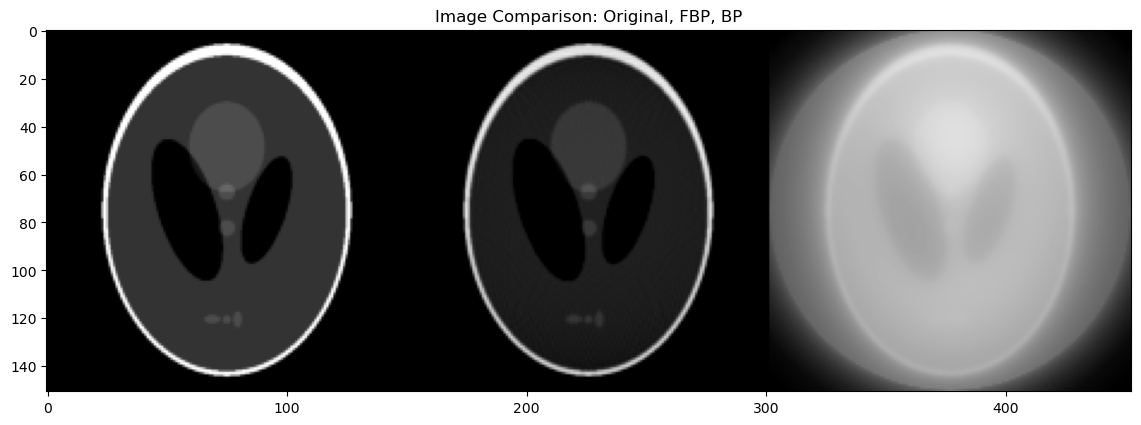

In [4]:

fbp = backproject(sf, theta)
fbp[fbp < 0] = 0

bp = backproject(s, theta) /100
bp[bp < 0] = 0


imc = np.concatenate((img, fbp, bp), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, FBP, BP')
plt.show()


### CT Reconstruction Using a Sparse System Matrix `A`

In the matrix-based formulation of tomography, we describe the entire projection and reconstruction process using a **linear system**:

$$
A \cdot x = b
$$

- `x` is the vectorized 2D image (unknown — what we want to reconstruct).
- `b` is the measured sinogram, flattened into a 1D vector.
- `A` is the **system matrix** that models the geometry of the scanner — each row of `A` represents the contribution of all pixels to one detector measurement at a specific angle.

This formulation allows us to use linear algebra to solve for `x`. The simplest solution is the **least squares estimate**:

$$
x = (A^\top A)^{-1} A^\top b
$$

But this direct inversion is **not practical** for real-world data due to:

#### 🔍 Key Challenges:
- **Memory usage**: `A` is typically very large but sparse (most entries are zero). For a 256×256 image and 1000 projections, `A` will have 256×1000×256×256 elements!
- **Storage**: We use a **sparse matrix representation** (e.g. CSR/COO) to store only the non-zero elements.
- **Computation**: Instead of inverting `A`, we often use **iterative solvers** like SIRT, SART or CGLS that only require **matrix-vector products** (`A @ x` and `A.T @ y`) — not the matrix itself.

#### 🧱 Constructing `A`:
You can build `A` manually by tracing ray paths from the source to each detector element at each angle. Each ray intersects a subset of pixels, and you compute how much each pixel contributes to the corresponding detector reading.

This process encodes:
- Geometry (angles, detector positions)
- Pixel grid layout
- Integration of intensity along ray paths

#### 🧠 Why Use the `A` Matrix Formulation?
- Provides a **ground truth model** for verifying custom forward/backprojector logic.
- Makes it easy to test and debug with linear solvers.
- Lets you use off-the-shelf optimization tools (e.g. Tikhonov regularization, sparsity constraints).

However, this approach **does not scale well** for large volumes or 3D data. That’s why modern toolkits (like ASTRA or ODL) avoid forming `A` explicitly — instead, they use **operator-based forward and backward projectors** that compute `A @ x` on the fly.

This notebook shows how to:
- Build a simple sparse matrix `A`
- Compare matrix-based and loop-based reconstructions
- Use `A` in iterative solvers like CGLS

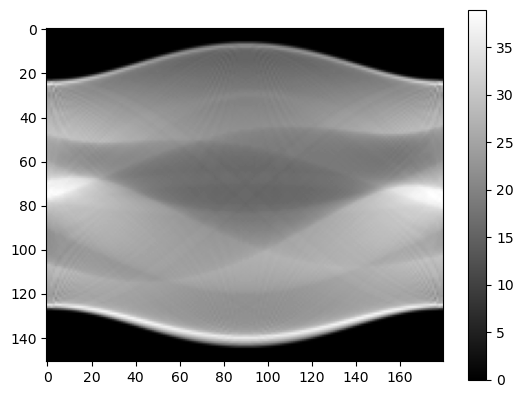

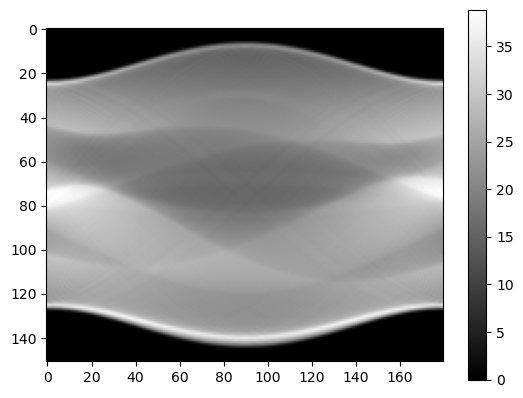

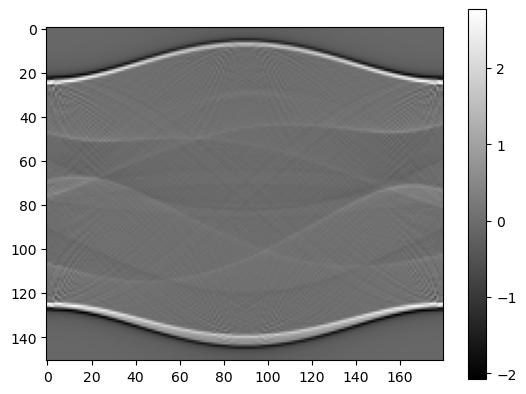

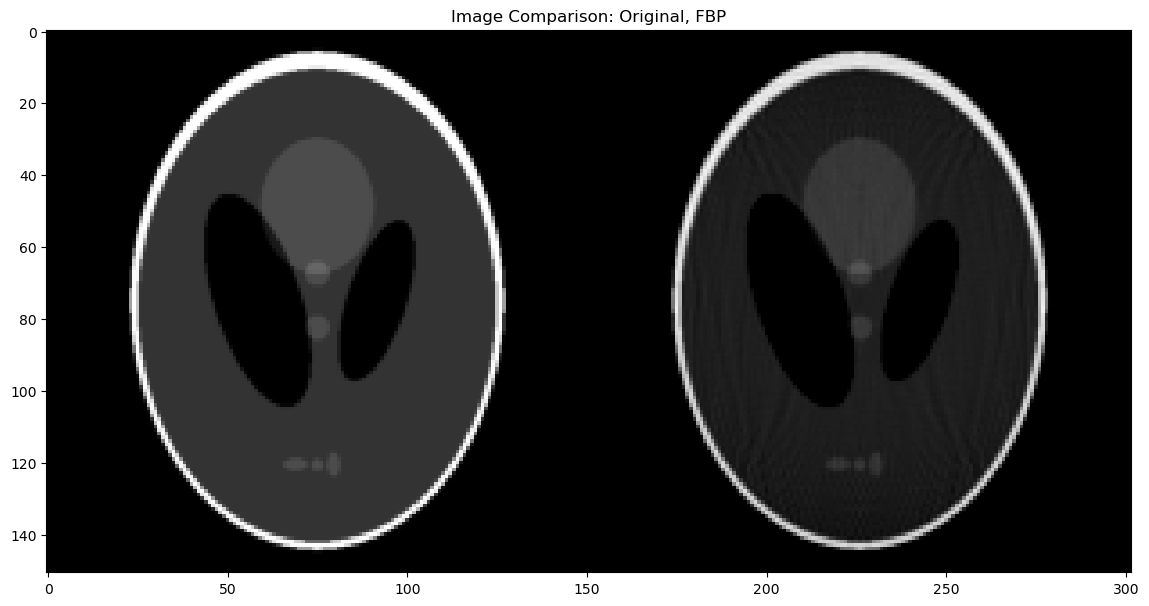

In [5]:

A = paralleltomo(N=img.shape[0], theta=theta + 90, p=img.shape[0], w=img.shape[0]-1)

b = A*img.flatten()
sA = np.transpose(np.reshape(b, (len(theta), npix)))

plt.figure(1);plt.clf()
plt.imshow(sA, cmap='gray')
plt.colorbar()
plt.show()

plt.figure(1);plt.clf()
plt.imshow(s, cmap='gray')
plt.colorbar()
plt.show()

sA = filter_sinogram(sA, filter_type='Ramp')

plt.figure(1);plt.clf()
plt.imshow(sA, cmap='gray')
plt.colorbar()
plt.show()

rec = backproject(sA, theta)
rec = np.fliplr(rec)
rec[rec < 0] = 0

imc = np.concatenate((img, rec), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, FBP')
plt.show()


In [6]:
from nDTomo.tomo.astra_tomo import astra_Amatrix

Aa = astra_Amatrix(img.shape[0], np.deg2rad(theta))

b = Aa*img.flatten()
sA = np.transpose(np.reshape(b, (len(theta), npix)))

plt.figure(1);plt.clf()
plt.imshow(sA, cmap='gray')
plt.colorbar()
plt.show()

sA = filter_sinogram(sA, filter_type='Ramp')

plt.figure(1);plt.clf()
plt.imshow(sA, cmap='gray')
plt.colorbar()
plt.show()

rec = backproject(sA, theta)
rec[rec < 0] = 0

imc = np.concatenate((img, rec), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, FBP')
plt.show()



AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## 🔁 Iterative Reconstruction from Sparse System Matrix

In this section, we reconstruct an image from projection data using various iterative algorithms. The reconstruction is based on solving the linear system:

$$
A \cdot x = b
$$

Where:

- $A$ is the **system matrix** (sparse, usually very large),
- $x$ is the **flattened image vector** we want to recover,
- $b$ is the **measured sinogram data**, i.e., projection measurements.

We assume that $A$ has been constructed correctly and that projecting the ground truth image via `b = A @ img.flatten()` gives us valid synthetic data.

---

## ⚙️ What the System Matrix `A` Represents

- The matrix $A$ encodes how each **ray path** intersects the image grid.
- It is extremely **sparse** — most rays intersect only a few pixels.
- Its shape is typically $(\text{num\_projections}, \text{num\_pixels})$.
- It’s built using ray-tracing or analytical models (e.g., parallel beam or fan beam).

---

## 🧠 Overview of the Algorithms

We demonstrate and compare three iterative reconstruction algorithms:

---

### ✅ CGLS (Conjugate Gradient Least Squares)

The `cgls` function solves the **least squares** problem:

$$
x = \arg\min_x \|A x - b\|^2
$$

This method is:

- Based on **Krylov subspaces** and updates the solution along conjugate directions,
- Often converges faster than row-based methods like ART or global methods like SIRT,
- Very effective for consistent, well-conditioned systems.

---

### ✅ SIRT (Simultaneous Iterative Reconstruction Technique)

This method applies the update rule:

$$
x^{(k+1)} = x^{(k)} + \lambda \cdot D \cdot A^\top \cdot M \cdot (b - A x^{(k)})
$$

Where:

- $M = \mathrm{diag}(1 / \|a_i\|^2)$ — row normalization to scale each ray’s contribution,
- $D = \mathrm{diag}(1 / \|a_j\|^2)$ — column normalization to balance pixel sensitivity,
- $\lambda$ — relaxation parameter (e.g., 0.5–1.0).

SIRT is:

- A **global update** method (uses all projections in each iteration),
- Known for producing **smooth and stable reconstructions**,
- Slow to converge but robust to noise and incomplete projections.

---

## 🖼️ Visualization and Comparison

Once the iterative algorithm finishes, we reshape the result and set the negative values to 0:

```python
x = np.reshape(xn, img.shape)
x[x < 0] = 0

In [7]:

b = Aa*img.flatten()

xn_cgls = cgls(Aa, b, n_iter=25)
xn_sirt = sirt(Aa,b, n_iter=25, relax=1.0)

xn_cgls = np.reshape(xn_cgls, img.shape)
xn_cgls[xn_cgls < 0] = 0
xn_sirt = np.reshape(xn_sirt, img.shape)
xn_sirt[xn_sirt < 0] = 0

imc = np.concatenate((img, xn_cgls, xn_sirt), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, CGLS, SIRT')
plt.show()  



NameError: name 'Aa' is not defined

### Moving from Matrix-Based to Functional Iterative Reconstruction

In the previous section, we implemented **CGLS** and **SIRT** using an explicitly constructed system matrix `A` that represents the forward projection model (i.e., how line integrals are formed from the image). This allowed us to reconstruct the image via matrix-vector operations like `A @ x` and `A.T @ r`.

However, this matrix-based approach has several limitations:

#### ❌ Disadvantages of the Matrix-Based Approach

- **Memory intensive**: For even modest image sizes (e.g., 256×256 pixels), the system matrix `A` becomes enormous and difficult to store in RAM, especially if stored densely.
- **Not scalable**: As image resolution increases, the memory and compute requirements grow quadratically or worse.
- **Construction complexity**: Building `A` to match the physics of the CT system (geometry, interpolation, spacing) requires careful attention.

---

### ✅ Introducing the Functional Approach

In this section, we reimplement both **CGLS** and **SIRT** using *functional forward and backward projectors*. These are Python functions (`forwardproject()` and `backproject()`) that simulate the action of `A @ x` and `A.T @ r` respectively, without ever constructing the matrix `A`.

Instead of using `A`, we now define:

- `forward(x)` → applies the Radon transform (i.e., forward projection of the image),
- `backward(r)` → applies the unfiltered backprojection (i.e., approximate adjoint of the forward operator).

These operators are used inside the iterative solvers `sirt_functional()` and `cgls_functional()`.

---

#### ✅ Advantages of the Functional Approach

- **Memory efficiency**: There is no need to construct or store the system matrix `A`.
- **Easier to implement**: The logic of the algorithms becomes more intuitive, especially for those with experience in image processing but not sparse linear algebra.
- **Customizable**: You can easily modify the forward/backward projectors to simulate different CT geometries, noise models, or physics (e.g., fan beam, limited angle, scattering).
- **More flexible**: Ideal for GPU-accelerated workflows and large-scale imaging problems.

---

#### ⚠️ Disadvantages of the Functional Approach

- **Slower per iteration**: Each iteration is computationally more expensive than the matrix-based version because the forward and backward projections involve image rotation, interpolation, and summing — all of which are slower than matrix-vector products.
- **Adjoint mismatch**: `forwardproject()` and `backproject()` are only *approximate adjoints* of each other. This leads to numerical mismatches that must be corrected carefully (e.g., by disabling normalization in `backproject()` when used inside CGLS).
- **No access to `A.T A`**: Preconditioning and spectral analysis are harder, as we never form the normal equations explicitly.

---

### 📌 What Happens in This Cell?

In the code below, we use our functional implementations of **CGLS** and **SIRT**, both running for 10 iterations. These are applied to the same sinogram `s` and angles `theta`. We concatenate the resulting images to visually compare:

1. The original image,
2. The CGLS reconstruction (functional),
3. The SIRT reconstruction (functional).

This allows us to visually assess:
- Whether both algorithms converge to a reasonable solution,
- How they differ in terms of sharpness, smoothness, and artefacts,
- How they compare to the previous matrix-based reconstructions in quality and computational speed.

Let’s take a look at the results.

Time taken for CPU SIRT and CGLS: 18.867450714111328


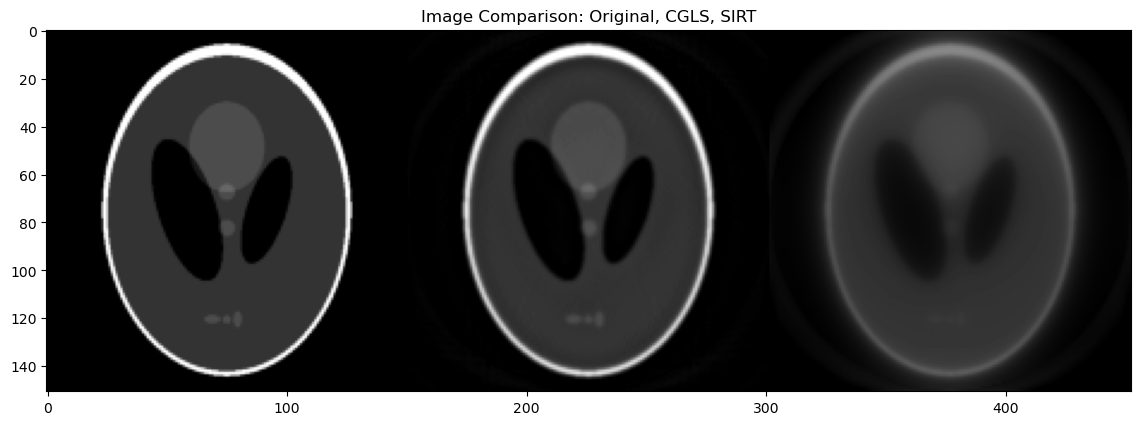

In [8]:

start = time.time()

x_sirt = sirt_functional(s, theta, n_iter=10)
x_cgls = cgls_functional(s, theta, n_iter=10)

print('Time taken for CPU SIRT and CGLS:', time.time() - start)


imc = np.concatenate((img, x_cgls, x_sirt), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, CGLS, SIRT')
plt.clim(0, 1)
plt.show()  


### GPU-Accelerated Functional CGLS and SIRT with PyTorch

In this final section, we extend our functional implementations of **CGLS** and **SIRT** to run on the GPU using **PyTorch**.

So far, our reconstructions have used NumPy-based CPU implementations of forward and backward projectors. While clear and flexible, these versions are relatively slow — particularly as the image size or number of projections increases. This is where PyTorch comes in.

#### 🚀 Why Use PyTorch?

- **Automatic GPU acceleration**: Simple tensor operations (e.g., summing, rotating) run seamlessly on CUDA.
- **Efficient memory management**: PyTorch handles data placement and device transfers efficiently, especially for batch computations.
- **Support for differentiability**: While not needed here, this can be useful for learned reconstruction models.
- **Same logic, faster execution**: The structure of the algorithm remains nearly identical to our NumPy code — but it runs much faster.

#### 🧱 Structure

- We reimplement the forward and backward projectors using PyTorch tensors.
- We use bilinear-rotated projections (with `torchvision.transforms.functional.rotate()` or similar).
- The reconstruction volume is stored and updated entirely on the GPU.
- We define `SIRT_update()` and `CGLS_update()` functions that use only PyTorch ops.

#### ✅ Advantages

- **Much faster iteration**: Especially for larger volumes (e.g., 256×256 or 512×512).
- **Scalable to 3D**: PyTorch can easily handle 3D volumes and batches of slices.
- **Drop-in replacement**: PyTorch versions are functionally equivalent to the NumPy ones — they just run faster.

#### ⚠️ Considerations

- You must have a working CUDA-enabled GPU with PyTorch installed.
- Precision differences may arise between CPU and GPU reconstructions (e.g., float32 accumulation).
- Visualization of intermediate results may require `.cpu().numpy()` transfers.

We now demonstrate PyTorch-based SIRT and CGLS reconstructions using the same sinogram data. This shows how high-performance iterative CT can be achieved in just a few lines of code — without matrix `A`, and without compromising algorithmic clarity.

In [9]:
import torch
from nDTomo.torch.tomo_torch import sirt_pytorch_functional, cgls_pytorch_functional

Time taken for GPU SIRT and CGLS: 3.996124029159546


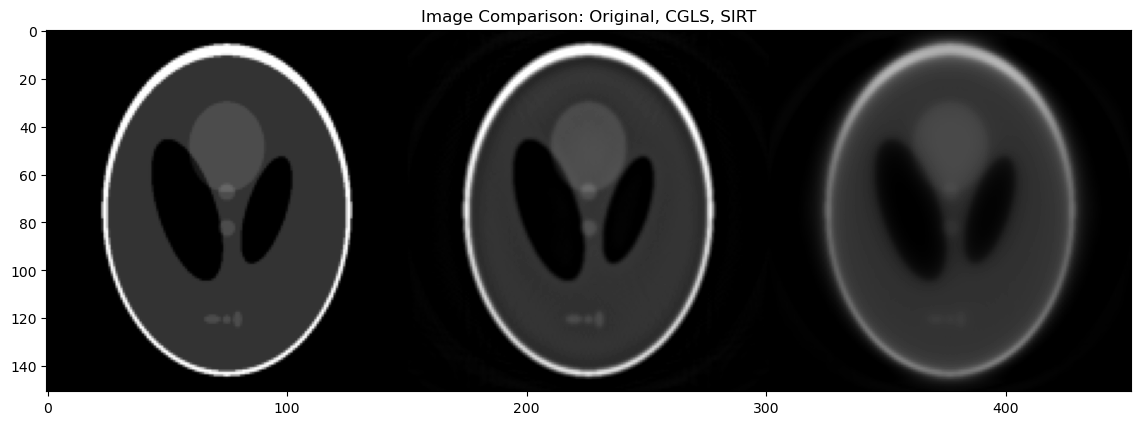

In [10]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convert numpy sinogram to torch and expand dims
sinos_gen = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)  # (1, npix, n_angles)

start = time.time() 

# Run GPU SIRT
recon_sirt = sirt_pytorch_functional(sinos_gen, theta, npix=npix, nch=sinos_gen.shape[0], n_iter=10, relax=0.01, device=device)

# Run CGLS on GPU
recon_cgls = cgls_pytorch_functional(sinos_gen, theta, npix=npix, nch=1, n_iter=10, device=device)

print('Time taken for GPU SIRT and CGLS:', time.time() - start)

imc = np.concatenate((img, recon_cgls, recon_sirt), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, CGLS, SIRT')
plt.clim(0, 1)
plt.show()  
